In [39]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Dict, Tuple, Set
import seaborn as sns
from dataclasses import dataclass

@dataclass
class InterpretabilityResults:
    """Store results from model interpretation analysis"""
    input_sequence: str
    target_output: str
    attention_patterns: torch.Tensor
    token_influences: Dict[str, float]
    embedding_distances: torch.Tensor
    perplexity_scores: torch.Tensor

class ModelInterpreter:
    def __init__(self, model_name: str = 'distilgpt2'):
        """Initialize the model interpreter with a specified language model"""
        print(f"Loading {model_name} for interpretation...")
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            attn_implementation="eager",
            output_attentions=True
        )
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        self.model.eval()
        
        # Cache embeddings for efficiency
        self.word_embeddings = self.model.get_input_embeddings().weight
        
    def analyze_target_behavior(
        self,
        target_output: str,
        input_length: int = 3,
        num_samples: int = 100,
        learning_rate: float = 0.01,
        optimization_steps: int = 101
    ) -> InterpretabilityResults:
        """
        Analyze model behavior by finding inputs that generate a target output
        and examining attention patterns and token relationships.
        """
        # Initialize input embeddings using target statistics
        base_stats = self._get_target_statistics(target_output)
        optimized_input = self._optimize_for_target(
            base_stats,
            target_output,
            input_length,
            num_samples,
            learning_rate,
            optimization_steps
        )
        
        # Analyze model behavior with optimized input
        return self._analyze_model_behavior(optimized_input, target_output)

    def _get_target_statistics(self, target_output: str) -> Dict[str, torch.Tensor]:
        """Calculate statistical properties of target output for initialization"""
        target_tokens = self.tokenizer.encode(target_output, return_tensors='pt')[0]
        target_embeddings = self.word_embeddings[target_tokens]
        
        return {
            'mean': target_embeddings.mean(dim=0),
            'std': target_embeddings.std(dim=0),
            'min': target_embeddings.min(dim=0)[0],
            'max': target_embeddings.max(dim=0)[0]
        }

    def _optimize_for_target(
        self,
        base_stats: Dict[str, torch.Tensor],
        target_output: str,
        input_length: int,
        num_samples: int,
        learning_rate: float,
        optimization_steps: int
    ) -> torch.Tensor:
        """Find input embeddings that generate the target output"""
        # Initialize inputs using target statistics
        input_embeddings = torch.normal(
            mean=base_stats['mean'].repeat(num_samples, input_length, 1),
            std=base_stats['std'].repeat(num_samples, input_length, 1)
        ).to(self.device)
        input_embeddings = torch.nn.Parameter(input_embeddings)
        
        optimizer = torch.optim.Adam([input_embeddings], lr=learning_rate)
        target_tokens = self.tokenizer.encode(target_output, return_tensors='pt')[0].to(self.device)
        
        best_loss = float('inf')
        best_input = None
        
        for step in range(optimization_steps):
            # Forward pass
            outputs = self.model(
                inputs_embeds=input_embeddings,
                output_attentions=True,
                return_dict=True
            )
            
            # Calculate loss based on target sequence probability
            logits = outputs.logits[:, -target_tokens.shape[0]:, :]
            loss = torch.nn.functional.cross_entropy(
                logits.reshape(-1, logits.shape[-1]),
                target_tokens.repeat(num_samples)
            )
            
            # Add regularization for embedding space validity
            embedding_distances = torch.cdist(
                input_embeddings.reshape(-1, input_embeddings.shape[-1]),
                self.word_embeddings
            ).min(dim=1)[0].mean()
            
            total_loss = loss + 0.1 * embedding_distances
            
            if total_loss.item() < best_loss:
                best_loss = total_loss.item()
                best_input = input_embeddings.detach().clone()
            
            # Optimization step
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            
            if step % 50 == 0:
                print(f"Step {step}: Loss = {total_loss.item():.4f}")
        
        return best_input

    def _analyze_model_behavior(
        self,
        input_embeddings: torch.Tensor,
        target_output: str
    ) -> InterpretabilityResults:
        """Analyze model behavior using optimized input"""
        with torch.no_grad():
            outputs = self.model(
                inputs_embeds=input_embeddings,
                output_attentions=True,
                return_dict=True
            )
        
        # Get closest tokens to input embeddings
        input_tokens = []
        for emb in input_embeddings[0]:
            distances = torch.norm(self.word_embeddings - emb, dim=1)
            closest_token = self.tokenizer.decode(distances.argmin())
            input_tokens.append(closest_token)
        
        input_sequence = ''.join(input_tokens)
        
        # Analyze attention patterns
        attention_patterns = torch.stack(outputs.attentions).mean(dim=(0, 1))
        
        # Calculate token influences
        token_influences = self._calculate_token_influences(
            attention_patterns,
            input_tokens,
            target_output
        )
        
        # Get embedding distances
        embedding_distances = torch.cdist(
            input_embeddings[0],
            self.word_embeddings
        )
        
        # Calculate perplexity
        perplexity = torch.exp(
            torch.nn.functional.cross_entropy(
                outputs.logits[0, :-1].reshape(-1, outputs.logits.shape[-1]),
                outputs.logits[0, 1:].argmax(dim=-1).reshape(-1)
            )
        )
        
        return InterpretabilityResults(
            input_sequence=input_sequence,
            target_output=target_output,
            attention_patterns=attention_patterns,
            token_influences=token_influences,
            embedding_distances=embedding_distances,
            perplexity_scores=perplexity
        )



    def _calculate_token_influences(
        self,
        attention_patterns: torch.Tensor,
        input_tokens: List[str],
        target_output: str
    ) -> Dict[str, float]:
        """Calculate the influence of each input token on the target output"""
        influences = {}
        for i, token in enumerate(input_tokens):
            influence_score = attention_patterns[i, :].mean().item()
            influences[token] = influence_score
        return influences



In [42]:

interpreter = ModelInterpreter()
results = interpreter.analyze_target_behavior(
        target_output="I am a Girl",
        input_length=10,
        num_samples=50
    )
print(results.input_sequence)
print(results.target_output)
print(results.token_influences)
print(results.perplexity_scores)

Loading distilgpt2 for interpretation...
Step 0: Loss = 6.8848
Step 50: Loss = 0.3844
Step 100: Loss = 0.3403
TheI Girl The Girl aIn am am Girl
I am a Girl
{'The': 0.10000000894069672, 'I': 0.09999999403953552, ' Girl': 0.10000000149011612, ' The': 0.09999999403953552, ' a': 0.10000000149011612, 'In': 0.09999999403953552, ' am': 0.10000000149011612}
tensor(12984.7500)


C:\Users\kanis\AppData\Local\Temp\ipykernel_44416\3148334781.py:97: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap(cmap)
C:\Users\kanis\AppData\Local\Temp\ipykernel_44416\3148334781.py:133: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(cmap)(np.linspace(0, 1, len(tokens)))
C:\Users\kanis\AppData\Local\Temp\ipykernel_44416\3148334781.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


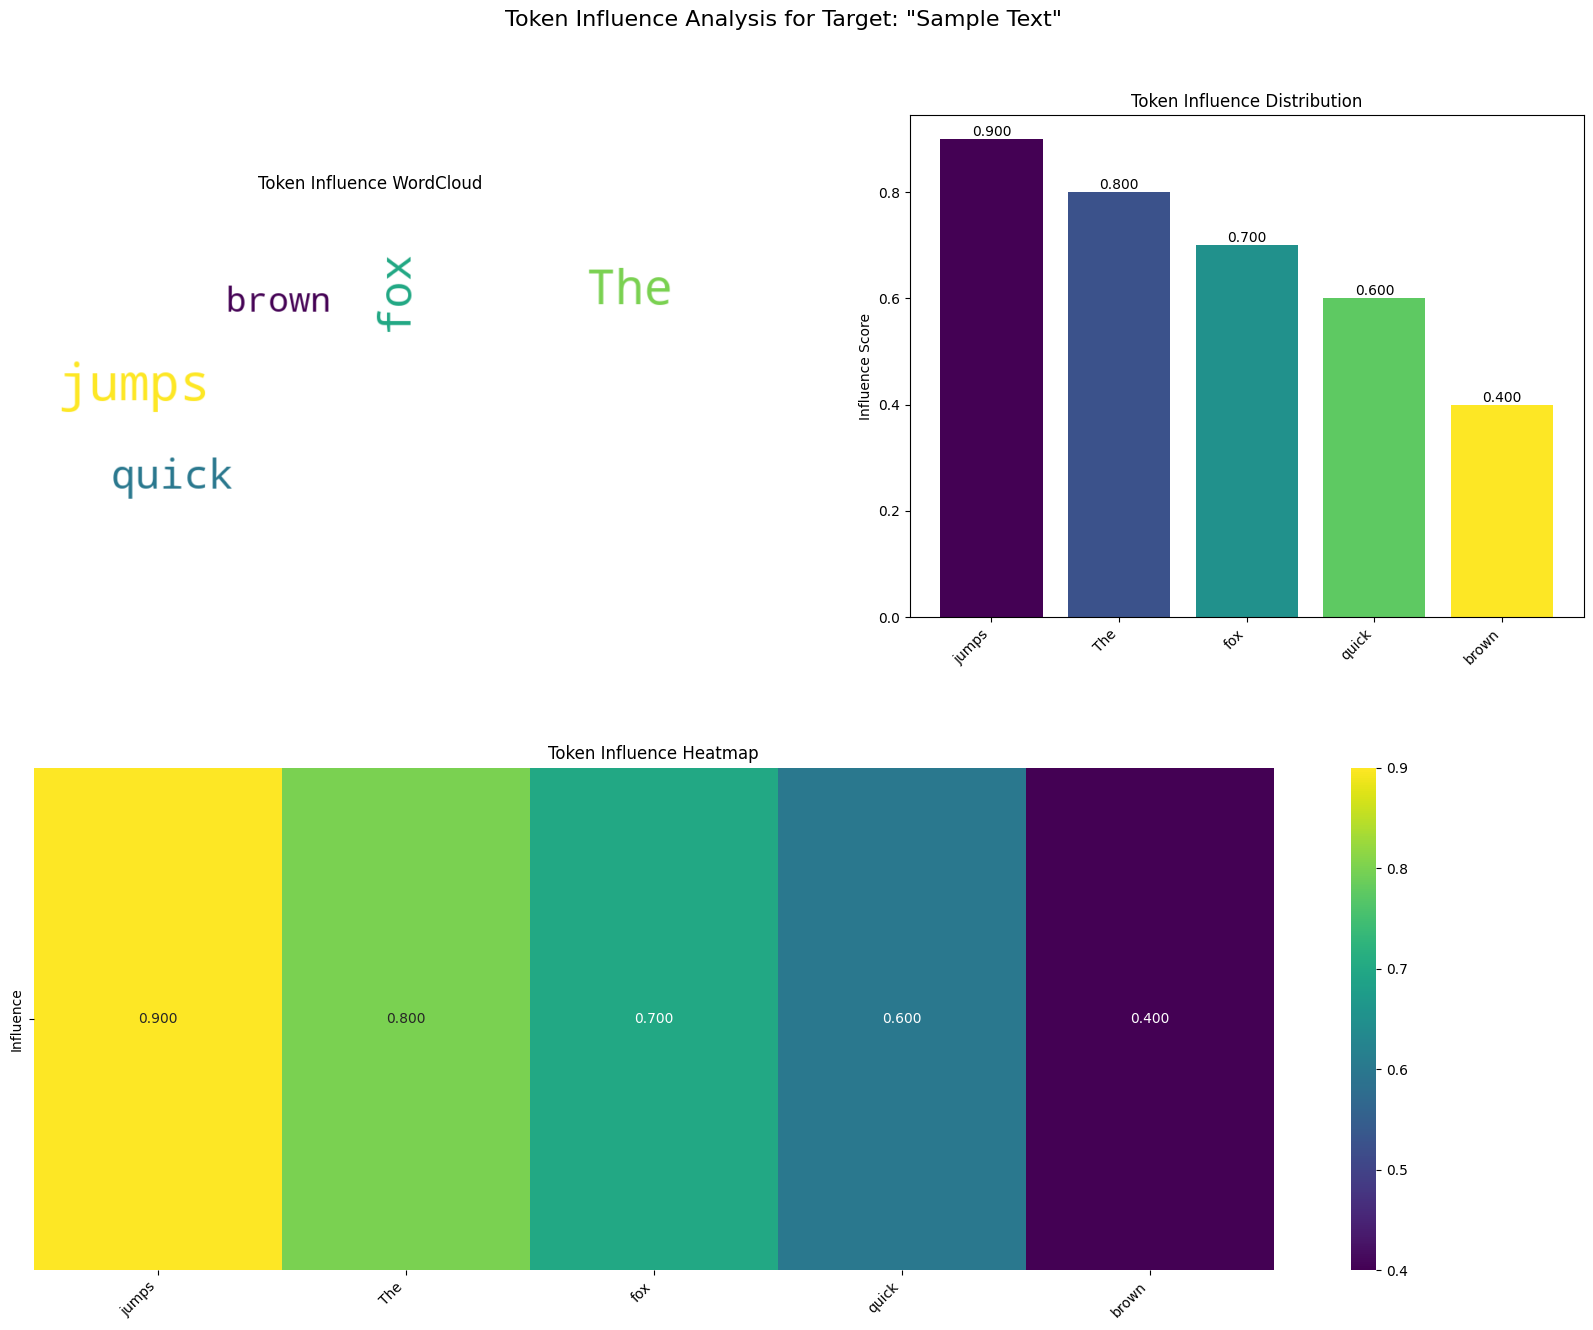

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from typing import Dict, Optional, Tuple, List
from dataclasses import dataclass
import pandas as pd
from wordcloud import WordCloud
import matplotlib.colors as mcolors

def visualize_tokens(
    token_influences: Dict[str, float],
    target_output: str,
    visualization_type: str = 'all',
    figsize: Tuple[int, int] = (15, 10),
    cmap: str = 'viridis',
    background_color: str = 'white',
    save_path: Optional[str] = None
) -> None:
    """
    Visualize token influences using multiple visualization techniques.
    
    Args:
        token_influences: Dictionary mapping tokens to their influence scores
        target_output: The target output string being analyzed
        visualization_type: Type of visualization ('wordcloud', 'bar', 'heatmap', 'all')
        figsize: Figure size for the plots
        cmap: Color map to use for the visualizations
        background_color: Background color for wordcloud
        save_path: Optional path to save the visualization
    """
    if visualization_type not in ['wordcloud', 'bar', 'heatmap', 'all']:
        raise ValueError("visualization_type must be 'wordcloud', 'bar', 'heatmap', or 'all'")

    # Sort tokens by influence for consistent visualization
    sorted_tokens = dict(sorted(token_influences.items(), key=lambda x: x[1], reverse=True))
    
    if visualization_type == 'all':
        fig = plt.figure(figsize=(20, 15))
        
        # Create subplot grid
        gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
        
        # Wordcloud
        ax1 = fig.add_subplot(gs[0, 0])
        _create_wordcloud(sorted_tokens, background_color, cmap, ax1)
        ax1.set_title('Token Influence WordCloud')
        
        # Bar plot
        ax2 = fig.add_subplot(gs[0, 1])
        _create_bar_plot(sorted_tokens, cmap, ax2)
        ax2.set_title('Token Influence Distribution')
        
        # Heatmap
        ax3 = fig.add_subplot(gs[1, :])
        _create_heatmap(sorted_tokens, cmap, ax3)
        ax3.set_title('Token Influence Heatmap')
        
        plt.suptitle(f'Token Influence Analysis for Target: "{target_output}"', size=16, y=0.95)
        
    else:
        plt.figure(figsize=figsize)
        if visualization_type == 'wordcloud':
            _create_wordcloud(sorted_tokens, background_color, cmap)
            plt.title(f'Token Influence WordCloud for "{target_output}"')
            
        elif visualization_type == 'bar':
            _create_bar_plot(sorted_tokens, cmap)
            plt.title(f'Token Influence Distribution for "{target_output}"')
            
        elif visualization_type == 'heatmap':
            _create_heatmap(sorted_tokens, cmap)
            plt.title(f'Token Influence Heatmap for "{target_output}"')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

def _create_wordcloud(
    token_influences: Dict[str, float],
    background_color: str,
    cmap: str,
    ax: Optional[plt.Axes] = None
) -> None:
    """Create wordcloud visualization of token influences"""
    # Normalize influence scores
    min_influence = min(token_influences.values())
    max_influence = max(token_influences.values())
    normalized_influences = {
        k: (v - min_influence) / (max_influence - min_influence)
        for k, v in token_influences.items()
    }
    
    # Create color function
    colormap = plt.cm.get_cmap(cmap)
    color_func = lambda word, **kwargs: mcolors.rgb2hex(
        colormap(normalized_influences[word])[:3]
    )
    
    # Generate wordcloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color=background_color,
        color_func=color_func,
        prefer_horizontal=0.7,
        min_font_size=10,
        max_font_size=60,
        relative_scaling=0.5
    ).generate_from_frequencies(token_influences)
    
    if ax is None:
        ax = plt.gca()
    
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')

def _create_bar_plot(
    token_influences: Dict[str, float],
    cmap: str,
    ax: Optional[plt.Axes] = None
) -> None:
    """Create bar plot of token influences"""
    if ax is None:
        ax = plt.gca()
    
    tokens = list(token_influences.keys())
    influences = list(token_influences.values())
    
    # Create color gradient
    colors = plt.cm.get_cmap(cmap)(np.linspace(0, 1, len(tokens)))
    
    bars = ax.bar(range(len(tokens)), influences, color=colors)
    ax.set_xticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=45, ha='right')
    ax.set_ylabel('Influence Score')
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2,
            height,
            f'{height:.3f}',
            ha='center',
            va='bottom',
            rotation=0
        )

def _create_heatmap(
    token_influences: Dict[str, float],
    cmap: str,
    ax: Optional[plt.Axes] = None
) -> None:
    """Create heatmap visualization of token influences"""
    if ax is None:
        ax = plt.gca()
    
    # Create matrix for heatmap
    tokens = list(token_influences.keys())
    influences = np.array(list(token_influences.values()))
    influence_matrix = influences.reshape(1, -1)
    
    sns.heatmap(
        influence_matrix,
        cmap=cmap,
        annot=True,
        fmt='.3f',
        cbar=True,
        ax=ax,
        xticklabels=tokens,
        yticklabels=['Influence']
    )
    
    ax.set_xticklabels(tokens, rotation=45, ha='right')

# Example usage
if __name__ == "__main__":
    # Sample token influences
    sample_influences = {
        'The': 0.8,
        'quick': 0.6,
        'brown': 0.4,
        'fox': 0.7,
        'jumps': 0.9
    }
    
    # Generate all visualizations
    visualize_tokens(
        sample_influences,
        target_output="Sample Text",
        visualization_type='all',
        cmap='viridis'
    )
    


In [55]:
from helpers import *

import torch
from matplotlib import pyplot as plt
from IPython import display
import numpy as np
import argparse
import json
import os
from collections import Counter
import random
import wandb

os.environ["WANDB_API_KEY"] ="61e79ad90458f5faea9605e7805f1f26268f0483"
os.environ["WANDB_SILENT"] = "true"


def optimise_input(model,
                   word_embeddings,
                   tokenizer,
                   device,
                   epochs=100,
                   lr=0.1,
                   no_reinit=False,
                   w_freq=10,  
                   rand_input=False,
                   local_input=False,
                   batch_size=20,
                   input_len=10,
                   target_output=' world',  
                   output_len=None,
                   dist_reg=0.1, 
                   perp_reg=0,
                   loss_type='log_prob_loss',
                   seed=0,
                   return_early=False,  # finishes if single optimised input is found
                   verbose=1,  
                   lr_decay=False,  # Use learning rate decay? If so, a scheduler gets invoked.
                   run_random=0,
                   equal_clusters=False,
                   penalise_repetition=False,
                   optimiser='Adam',
                   **kwargs):

    if run_random > 0:
        random_ix = (torch.rand(1) * word_embeddings.shape[0]).int()
        target_output = tokenizer.decode(random_ix)  # Converts token index to string representation
        wandb.config.update({'target_output': target_output}, allow_val_change=True)

    print('Optimising input of length {} to maximise output logits for "{}"'.format(input_len, target_output))
    done = None

    output_ix = tokenizer.encode(target_output, return_tensors='pt')[0].to(device)

    word_embeddings = word_embeddings / torch.sqrt(torch.sum(word_embeddings**2, dim=-1, keepdim=True))

    optimised_inputs = set()
    optimised_tokens = []
    metrics_table = wandb.Table(columns=['Input', 'Output', 'Loss', 'Perplexity', 'Distance', 'Probs'])

    if output_len == None or output_len < output_ix.shape[
        0]:  
        output_len = output_ix.shape[
            0]  
    else:
        possible_target_positions = torch.stack(
            [torch.arange(0, output_ix.shape[0]) + i for i in range(output_len - output_ix.shape[0] + 1)])

    if rand_input == True:
        start_input = word_embeddings[torch.randperm(word_embeddings.shape[0])[:input_len * batch_size]].reshape(
            batch_size, input_len, -1)
    elif local_input == True:
        local_embs = closest_tokens(word_embeddings[output_ix].mean(dim=0), word_embeddings, tokenizer, n=batch_size)[-1].unsqueeze(1)
        start_input = local_embs.repeat(1, input_len, 1)
    else:
        num_clusters = batch_size * input_len
        _, centroids = kkmeans(word_embeddings.detach(), num_clusters, seed=seed,
                               equal_clusters=equal_clusters)
        start_input = centroids.reshape(batch_size, input_len, -1)

    input = torch.nn.Parameter(start_input.to(device), requires_grad=True)

    if optimiser == 'Adam':
        optimiser = torch.optim.Adam([input], lr=lr, eps=0.0001)
    elif optimiser == 'SGD':
        optimiser = torch.optim.SGD([input], lr=lr)
    else:
        print('Unsupported optimiser: ', optimiser)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 'min', patience=20, cooldown=20, factor=0.5)

    for e in range(epochs):
        norm_input = input / torch.sqrt(torch.sum(input**2, dim=-1, keepdim=True))
        logits, emb, perp = model_emb(model, norm_input,
                                      word_embeddings, output_len)

        probs = torch.softmax(logits, dim=-1)

        perp_loss = perp.mean()  # across all elements in the batch

        if output_len > output_ix.shape[0]:
            target_logits = logits[:, possible_target_positions, output_ix].max(dim=1)[0]
            target_probs = probs[:, possible_target_positions, output_ix].max(dim=1)[0]

        else:
            target_logits = logits[:, torch.arange(output_len), output_ix]
            target_probs = probs[:, torch.arange(output_len), output_ix]

        token_dist, closest_ix = [], []
        for b in norm_input:
            tds, cixs = [], []
            for be in b:
                _, cix, td, _ = closest_tokens(be, word_embeddings, tokenizer)
                tds.append(td)
                cixs.append(cix)
            token_dist.append(torch.stack(tds))
            closest_ix.append(torch.stack(cixs))

        token_dist, closest_ix = torch.stack(token_dist).squeeze(-1), torch.stack(closest_ix).squeeze(-1)

        mean_token_dist = token_dist.mean()

        if loss_type == 'log_prob_loss':
            loss = -torch.log(target_probs)
        elif loss_type == 'CE':
            if output_len > 1:
                print('CE not supported with output length > 1.')
                return
            loss = torch.nn.functional.cross_entropy(logits.swapaxes(-1, -2), output_ix.repeat(batch_size, 1),
                                                     reduction='none')
        else:
            print(loss_type + 'is not implemented.')
            return

        batch_loss = loss.mean()

        total_loss = torch.stack([mean_token_dist * dist_reg, batch_loss, perp_loss * perp_reg]).mean()

        if penalise_repetition:
            rep_penalty = logits[:, :input_len, output_ix].sum()
            total_loss += rep_penalty
        else:
            rep_penalty = 0

        model_outs = model.generate(closest_ix, max_length=output_len + input_len)
      
        for b in range(batch_size):
            if target_output in tokenizer.decode(model_outs[b][input_len:]):
                if tokenizer.decode(model_outs[b]) not in optimised_inputs:
                    optimised_tokens += [tokenizer.decode(t) for t in model_outs[b][:input_len]]

                    counts = Counter(optimised_tokens)
                    labels, values = zip(*counts.items())

                    data = [[label, val] for (label, val) in zip(labels, values)]
                    table = wandb.Table(data=data, columns=["Token", "Count"])
                    wandb.log({"token_freqs": wandb.plot.bar(table, "Token",
                                                             "Count", title="Token Freqs")})

                    done = tokenizer.decode(model_outs[b])
                    optimised_inputs.add(done)
                    metrics_table.add_data(*[tokenizer.decode(model_outs[b][:input_len]),
                                             tokenizer.decode(model_outs[b][input_len:])] + torch.stack(
                        [loss.squeeze(-1)[b].mean(), perp[b], token_dist.mean(dim=1)[b]], dim=-1).tolist() + [target_probs[
                                                b].tolist()])
                    wandb.log({'Optimised Inputs': wandb.Html(
                        ''.join(['<p>{}.{}</p>'.format(i, repr(s)) for i, s in enumerate(optimised_inputs)]))})

                if no_reinit == False:
                    if rand_input == True or local_input == True:
                        input.data[b] = word_embeddings[torch.randperm(word_embeddings.shape[0])[:input_len]].reshape(1,
                                                                                                                      input_len,
                                                                                                                      -1).to(
                            device)
                    else:
                        rand_centroids = centroids[np.random.randint(0, batch_size, size=input_len)].unsqueeze(0)
                        input.data[b] = rand_centroids

        if ((e + 1) % w_freq == 0) or done and return_early:

            print("Optimised Inputs:", optimised_inputs)
            print('{}/{} Output Loss: {} Emb Dist Loss: {} Perp Loss: {} LR: {}'.format(e + 1, epochs, batch_loss,
                                                                                        mean_token_dist, perp_loss,
                                                                                        optimiser.param_groups[0][
                                                                                            'lr']))
            if verbose == 3:
                print('Target Probs: {}\nTarget Logits: {}\nInput Dists: {}\nInput Perplexity: {}\n'.format(
                    target_probs.detach().cpu().numpy(), target_logits.detach().cpu().numpy(),
                    token_dist.detach().cpu().numpy(), perp.detach().reshape(-1).cpu().numpy()))

            closest_embeddings = []

            for b in range(batch_size):
                if verbose > 0:
                    if verbose == 2:
                        print(b, repr(' Raw embeddings: {}'.format(''.join([closest_tokens(e)[0][0] for e in emb[b]]))))

                    print(b, repr(' Closest embeddings: {}'.format(tokenizer.decode(model_outs[b]), '\n')))
                    closest_embeddings.append(tokenizer.decode(model_outs[b]))

            wandb.log({'Closest Embeddings': wandb.Html(
                ''.join(['<p>{}.{}</p>'.format(i, repr(ce)) for i, ce in enumerate(closest_embeddings)])),
                       'Total Loss': total_loss, 'Mean Token Distance': mean_token_dist, 'Mean Loss': batch_loss,
                       'Mean Perplexity Loss': perp_loss, 'Epoch': e, 'LR': optimiser.param_groups[0]['lr'],
                       'Num Inputs Found': len(optimised_inputs), 'Repetition Penalty': rep_penalty})

            if done and return_early:
                print('\nOptimised Input: "{}"'.format(done))
                return {'Metrics': metrics_table}

        optimiser.zero_grad()
        total_loss.backward()
        optimiser.step()

        if lr_decay:
            scheduler.step(total_loss)
        done = None

    return {'Metrics': metrics_table}


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--wandb_user', type=str, default='jessicamarycooper')
    parser.add_argument('--model_name', type=str, default='gpt2')
    parser.add_argument('--epochs', type=int, default=100)
    parser.add_argument('--lr', type=float, default=0.1)
    parser.add_argument('--no_reinit', action='store_true')
    parser.add_argument('--w_freq', type=int, default=10)
    parser.add_argument('--rand_input', action='store_true')
    parser.add_argument('--local_input', action='store_true')
    parser.add_argument('--batch_size', type=int, default=20)
    parser.add_argument('--input_len', type=int, default=10)
    parser.add_argument('--target_output', type=str, default=' world')
    parser.add_argument('--output_len', type=int)
    parser.add_argument('--dist_reg', type=float, default=0.1)
    parser.add_argument('--perp_reg', type=float, default=0)
    parser.add_argument('--loss_type', type=str, default='log_prob_loss')
    parser.add_argument('--seed', type=int, default=0)
    parser.add_argument('--return_early', action='store_true')
    parser.add_argument('--verbose', type=int, default=1)
    parser.add_argument('--lr_decay', action='store_true')
    parser.add_argument('--note', type=str, default='')
    parser.add_argument('--run_test_set', type=int, default=-1)
    parser.add_argument('--run_random', type=int, default=0)
    parser.add_argument('--optimiser', type=str, default='Adam')
    parser.add_argument('--equal_clusters', action='store_true')
    parser.add_argument('--penalise_repetition', action='store_true')

    args = parser.parse_args()

    test_sets = [
        [' externalToEVA', 'quickShip', ' TheNitrome', 'embedreportprint', 'rawdownload', 'reportprint', ' サーティ',
         ' RandomRedditor', 'oreAndOnline', 'InstoreAndOnline', ' externalTo', 'StreamerBot', 'ActionCode', 'Nitrome', ' SolidGoldMagikarp', 'PsyNetMessage'],
        [' girl', ' boy', 'good', ' evil', ' science', ' art', ' England', ' USA'],
        [' newcom', 'slaught', 'senal', 'imei']]

    torch.manual_seed(args.seed)
    random.seed(0)
    np.random.seed(0)

    args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

    print('Using {} device.'.format(args.device))

    args.model, args.word_embeddings, args.tokenizer = load_all(args.model_name, args.device)

    if args.run_test_set > -1:
        for to in test_sets[args.run_test_set]:
            args.target_output = to
            run = wandb.init(config=args, project='backwards', entity=args.wandb_user, reinit=True)
            results = optimise_input(**vars(args))
            wandb.log(results)
            run.finish()

    if args.run_random > 0:

        seeds = (torch.rand(args.run_random) * 60000).int()
        for r in range(args.run_random):
            args.seed = seeds[r]
            args.target_output = 'RANDOM'
            run = wandb.init(config=args, project='backwards', entity=args.wandb_user, reinit=True)
            results = optimise_input(**vars(args))
            wandb.log(results)
            run.finish()

    if args.run_test_set == -1 and args.run_random == 0:
        run = wandb.init(config=args, project='backwards', entity=args.wandb_user, reinit=True)
        results = optimise_input(**vars(args))
        wandb.log(results)
        run.finish()

usage: ipykernel_launcher.py [-h] [--wandb_user WANDB_USER]
                             [--model_name MODEL_NAME] [--epochs EPOCHS]
                             [--lr LR] [--no_reinit] [--w_freq W_FREQ]
                             [--rand_input] [--local_input]
                             [--batch_size BATCH_SIZE] [--input_len INPUT_LEN]
                             [--target_output TARGET_OUTPUT]
                             [--output_len OUTPUT_LEN] [--dist_reg DIST_REG]
                             [--perp_reg PERP_REG] [--loss_type LOSS_TYPE]
                             [--seed SEED] [--return_early]
                             [--verbose VERBOSE] [--lr_decay] [--note NOTE]
                             [--run_test_set RUN_TEST_SET]
                             [--run_random RUN_RANDOM] [--optimiser OPTIMISER]
                             [--equal_clusters] [--penalise_repetition]
ipykernel_launcher.py: error: unrecognized arguments: --f=c:\Users\kanis\AppData\Roaming\jupyter\r

SystemExit: 2